In [ ]:
import time
import pickle
from io import BytesIO

import keras
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud import storage
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, LSTM



In [3]:
import os
from random import shuffle

from keras.utils import Sequence

DATA_DIRECTORY = 'data/cached_records'

BUCKET_NAME = 'ekg-network'
MAX_LENGTH = 120012
NUM_CHANNELS = 15


def get_bucket(bucket_name=BUCKET_NAME):
    storage_client = storage.Client()

    bucket = storage_client.get_bucket(bucket_name)
    
    return bucket


def list_blob_names(bucket_name=BUCKET_NAME):
    bucket = get_bucket(bucket_name=bucket_name)
    
    blob_names = [b.name for b in bucket.list_blobs()]
    
    return blob_names


def get_unpickled_blob(blob_name):
    bucket = get_bucket()
    
    blob = bucket.get_blob(blob_name)

    with BytesIO() as b:
        blob.download_to_file(b)
        b.seek(0)

        data = pickle.load(b)

    return data
    

def pad_sequence(sequence, max_len=MAX_LENGTH):
    pad_width = ((0,max_len - sequence.shape[0]), (0, 0))
    
    return np.pad(sequence, pad_width, mode='constant', constant_values=0)


def get_train_dev_test_filenames(fraction=0.15):
    blob_names = list_blob_names(bucket_name=BUCKET_NAME)
    
    shuffle(blob_names)
    
    n_holdouts = int(fraction * len(blob_names))
    
    train = blob_names[:-2 * n_holdouts]
    dev = blob_names[-2 * n_holdouts: -n_holdouts]
    test = blob_names[-n_holdouts:]
    
    return train, dev, test


class CacheBatchGenerator(Sequence):

    def __init__(self, filenames, batch_size, basedir=DATA_DIRECTORY):
        self.filenames = filenames
        self.batch_size = batch_size
        self.basedir = basedir

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        print('CacheBatchGenerator is getting idx {} of {}'.format(idx, self.__len__()))
        
        batch_filenames = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        batch = []
        for filename in batch_filenames:
            
            data = get_unpickled_blob(filename)
                
            batch.append(data)
        
        batch_x, batch_y = z
        
        
        ip(*batch)
        
        batch_x = [pad_sequence(x) for x in batch_x]
        batch_x = np.stack(batch_x)
        
        
        batch_y = [1 if r == 'Myocardial infarction' else 0 for r in batch_y]
        batch_y = np.array(batch_y).reshape(-1, 1)
        
        return batch_x, batch_y
    
trainf, devf, testf = get_train_dev_test_filenames()
tmp_generator = CacheBatchGenerator(trainf, 20)
tmp_generator[0]

CacheBatchGenerator is getting idx 0 of 20


(array([[[-1.6600e-01, -3.0195e+00, -2.8525e+00, ..., -2.4750e-01,
          -2.0590e+00,  4.7500e-02],
         [-1.7600e-01, -3.0185e+00, -2.8415e+00, ..., -2.4800e-01,
          -2.0550e+00,  4.8000e-02],
         [-1.7950e-01, -3.0195e+00, -2.8390e+00, ..., -2.4900e-01,
          -2.0570e+00,  4.7500e-02],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00, ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],
 
        [[-4.1600e-01, -2.4300e-01,  1.7200e-01, ..., -6.2500e-02,
           2.1700e-01,  1.4500e-02],
         [-4.2750e-01, -2.4800e-01,  1.7900e-01, ..., -6.7500e-02,
           2.0750e-01,  1.2000e-02],
         [-4.0700e-01, -2.3750e-01,  1.6900e-01, ..., -6.8000e-02,
           1.9250e-01,  9.0000e-03],
         ...,
         [ 0.0000e+00,  0.0000e+0

In [4]:
def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [5]:
def get_random_hyperparameters():
    train_batch, _, _ = get_train_dev_test_filenames()
    
    return {
        'num_hidden_units': np.random.randint(4, 100),
        'batch_size': np.random.randint(10, int(len(train_batch) / 2)),
        'learning_rate': 10**(-4 * np.random.random())
    }

get_random_hyperparameters()

{'batch_size': 101,
 'learning_rate': 0.3438833782250162,
 'num_hidden_units': 47}

metrics to collect: 
- history (with loss, accuracy, f1 score)
- time to run 10 epochs
- metrics on dev set

In [6]:
def run_model_with_random_hyperparameters(n_epochs=5):
    results = {}
    
    hyperparameters = get_random_hyperparameters()
    
    print('----DEBUG----')
    train_files, dev_files, _ = get_train_dev_test_filenames()
    train_files = train_files[:10]
    dev_files = dev_files[:10]
    
    hyperparameters = {
        'num_hidden_units': 2,
        'batch_size': 10,
        'learning_rate': 0.0001
    }
    
    
    print('trying parameters: {}'.format(hyperparameters))
    results['hyperparameters'] = hyperparameters
    
    batch_size = hyperparameters['batch_size']
    num_hidden_units = hyperparameters['num_hidden_units']
    learning_rate = hyperparameters['learning_rate']
    
    # Build model
    optimizer = Adam(lr=learning_rate)
    
    model = Sequential([
        LSTM(num_hidden_units, input_shape=(MAX_LENGTH, NUM_CHANNELS)),
        Dense(1, activation='sigmoid'),
    ])

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_score])
    
    results['model'] = model
    
    # Train model
    t_before = time.time()
    
    print('----DEBUG----')
#     train_files, dev_files, _ = get_train_dev_test_filenames()
    
    training_batch_generator = CacheBatchGenerator(train_files, batch_size=batch_size)
    dev_batch_generator = CacheBatchGenerator(dev_files, batch_size=min(batch_size, len(dev_files)))
    
    history = model.fit_generator(
        generator=training_batch_generator,
        validation_data=dev_batch_generator,
        epochs=n_epochs,
        use_multiprocessing=True,
        workers=16,
        max_queue_size=32,
        verbose=2)
    
    results['history'] = history
    
    t_after = time.time()
    total_time = t_after - t_before
    results['training_time'] = total_time
    
    # Test model
    training_batch_generator = CacheBatchGenerator(train_files, batch_size=batch_size)
    dev_batch_generator = CacheBatchGenerator(dev_files, batch_size=min(batch_size, len(dev_files)))
    
    results['train_metrics'] = model.evaluate_generator(training_batch_generator)
    results['dev_metrics'] = model.evaluate_generator(dev_batch_generator)
    
    # Print results
    print('metrics names: ', model.metrics_names)
    print('train_scores: ', results['train_metrics'])
    print('dev_scores: ', results['dev_metrics'])
   
    plt.figure()
    plt.plot(history.history['loss'])
    plt.title(hyperparameters)
    plt.show()
    
    return results




DEBUG: this should be higher

testing model 1 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 605s - loss: 0.6859 - acc: 0.2000 - f1_score: nan - val_loss: 0.6287 - val_acc: 0.9000 - val_f1_score: 0.9333
Epoch 2/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 589s - loss: 0.6858 - acc: 0.8000 - f1_score: 0.8750 - val_loss: 0.6286 - val_acc: 0.9000 - val_f1_score: 0.9333
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
metrics names:  ['loss', 'acc', 'f1_score']
train_scores:  [0.6855672597885132, 0.800000011920929, 0.875]
dev_scores:  [0.62

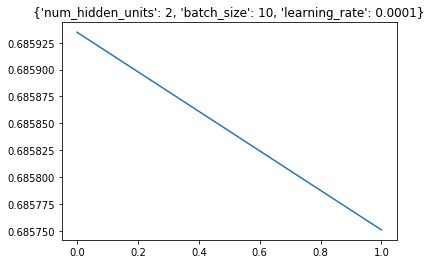


testing model 2 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2

CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 338s - loss: 0.7127 - acc: 0.4000 - f1_score: nan - val_loss: 0.7433 - val_acc: 0.1000 - val_f1_score: nan
Epoch 2/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 254s - loss: 0.7127 - acc: 0.4000 - f1_score: nan - val_loss: 0.7433 - val_acc: 0.1000 - val_f1_score: nan
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
metrics names:  ['loss', 'acc', 'f1_score']
train_scores:  [0.7126089334487915, 0.4000000059604645, nan]
dev_scores:  [0.7432779669761658, 0.10000000149011612, n

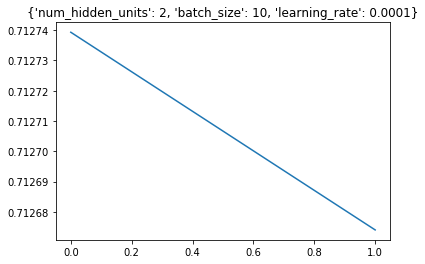


testing model 3 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 390s - loss: 0.6867 - acc: 0.3000 - f1_score: nan - val_loss: 0.6815 - val_acc: 0.9000 - val_f1_score: 0.9333
Epoch 2/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 294s - loss: 0.6867 - acc: 0.8000 - f1_score: 0.8571 - val_loss: 0.6815 - val_acc: 0.9000 - val_f1_score: 0.9333
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
metrics names:  ['loss', 'acc', 'f1_score']
train_scores:  [0.6866247057914734, 0.800000011920929, 0.8571428656578064]
dev_scores:  [0.6815100312232971, 

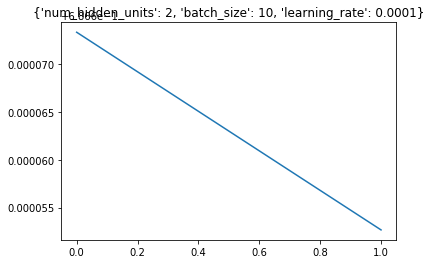


testing model 4 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2

CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 406s - loss: 0.6829 - acc: 0.3000 - f1_score: nan - val_loss: 0.6931 - val_acc: 0.8000 - val_f1_score: 0.8889
Epoch 2/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
 - 280s - loss: 0.6829 - acc: 0.7000 - f1_score: 0.7692 - val_loss: 0.6931 - val_acc: 0.8000 - val_f1_score: 0.8889
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
metrics names:  ['loss', 'acc', 'f1_score']
train_scores:  [0.6828147172927856, 0.699999988079071, 0.7692307233810425]
dev_scores:  [0.6930517554283142,

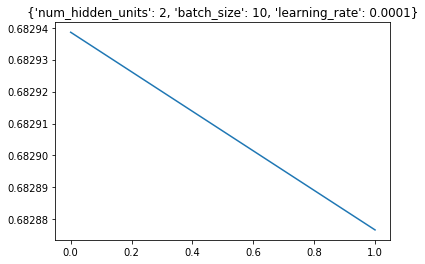


testing model 5 of 5
----DEBUG----
trying parameters: {'num_hidden_units': 2, 'batch_size': 10, 'learning_rate': 0.0001}
----DEBUG----
Epoch 1/2
Epoch 1/2
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1
CacheBatchGenerator is getting idx 0 of 1


In [ ]:
N_MODELS = 5

print('DEBUG: this should be higher')
N_EPOCHS = 2

model_test_results = []
for i in range(N_MODELS):
    print('\ntesting model {} of {}'.format(i + 1, N_MODELS))
    
    try:
        model_result = run_model_with_random_hyperparameters(n_epochs=N_EPOCHS)

        model_test_results.append(model_result)
    except KeyboardInterrupt:
        print('Test Interrupted.')
        break
    
